## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

### Начнем с алгоритма RandomForestClassifier без генерации фич с изображения, прикинем возможную точность

In [4]:
x_train , x_test , y_train, y_test = train_test_split(train_img.reshape(train_img.shape[0],28*28),train_label,test_size=0.2)

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
randforclf = RandomForestClassifier()

In [7]:
randforclf.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
y_pred = randforclf.predict(x_test)

In [9]:
accuracy_score(y_test,y_pred)

0.9363095238095238

In [10]:
confusion_matrix(y_test,y_pred)

array([[835,   0,   1,   1,   0,   4,   7,   0,   2,   1],
       [  0, 905,   6,   5,   1,   3,   2,   2,   1,   1],
       [ 10,   3, 788,   8,   7,   1,   4,   9,   3,   1],
       [  6,   6,  22, 792,   1,  10,   2,   9,  16,   6],
       [  4,   2,   0,   1, 767,   0,   7,   1,   3,  19],
       [ 13,   5,   2,  29,   5, 696,   7,   1,  17,   3],
       [  4,   2,   4,   0,   5,   5, 803,   1,   6,   0],
       [  1,  10,  12,   7,   9,   1,   0, 792,   3,  15],
       [  7,   3,  13,  22,  11,  15,   3,   0, 718,   7],
       [  4,   0,   4,  14,  37,  14,   2,  11,   3, 769]], dtype=int64)

В целом очень неплохо. Попробуем сгенерить фичи из изображения.

## Визуализируем исходные данные

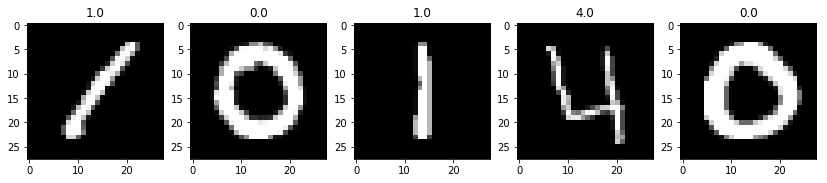

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [12]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [13]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [14]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [15]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

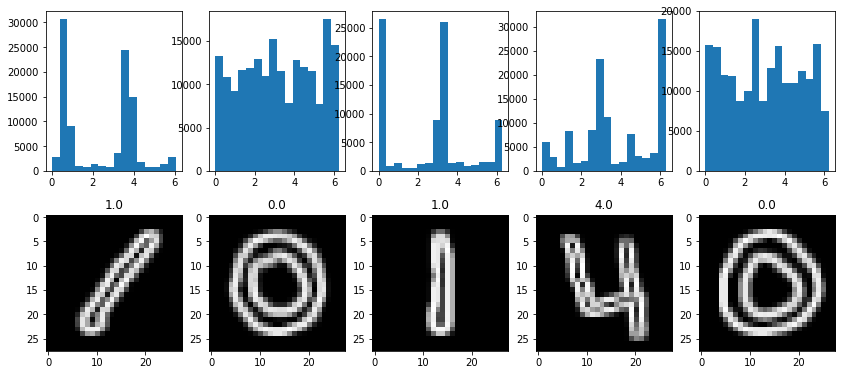

In [16]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [17]:
train_hist = np.zeros((len(train_img), 64))
test_hist = np.zeros((len(test_img), 64))

Однако, чтобы улучшить метрику качества accuracy попрорбуем получить гистограмму не для всей картинке сразу, а разделим картинку на 4 части, получим 4 гистограммы, и соединим их в одну, нормируя каждую гистограмму. 

In [18]:
for im in range(0,train_hist.shape[0]):
    hist_=[]
    for i in range(0,2):   
        for j in range(0,2):
            hist, borders = np.histogram(train_theta[im,14*i:14*(i+1),14*j:14*(j+1)],
                                 bins=16,
                                 range=(0., 2.0*np.pi),
                                 weights=train_g[im,14*i:14*(i+1),14*j:14*(j+1)])
            if hist.sum()!=0:
                hist = hist / hist.sum()
            hist_.extend(hist)            
    train_hist[im]=hist_

In [19]:
for im in range(0,test_hist.shape[0]):
    hist_=[]
    for i in range(0,2):   
        for j in range(0,2):
            hist, borders = np.histogram(test_theta[im,14*i:14*(i+1),14*j:14*(j+1)],
                                 bins=16,
                                 range=(0., 2.0*np.pi),
                                 weights=test_g[im,14*i:14*(i+1),14*j:14*(j+1)])
            if hist.sum()!=0:
                hist = hist / hist.sum()            
            hist_.extend(hist)
    test_hist[im]=hist_

## Разбиваем выборку на обучение и валидацию

In [20]:
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [21]:
clf_rfc = RandomForestClassifier(n_estimators=300, n_jobs=-1,random_state=42)

In [22]:
clf_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
y_val_rfc = clf_rfc.predict(x_val)

## Оцениваем качество решение на валидационной выборке

In [24]:
print('Accuracy: %s' % accuracy_score(y_val, y_val_rfc))

Accuracy: 0.9613095238095238


Классно! С помощью фичей на основе изображения удалось увеличить метрику на 3%.

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_rfc))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       816
         1.0       0.98      0.98      0.98       909
         2.0       0.94      0.96      0.95       846
         3.0       0.96      0.96      0.96       937
         4.0       0.98      0.94      0.96       839
         5.0       0.97      0.96      0.96       702
         6.0       0.95      0.97      0.96       785
         7.0       0.97      0.95      0.96       893
         8.0       0.94      0.95      0.95       835
         9.0       0.95      0.95      0.95       838

   micro avg       0.96      0.96      0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [26]:
print(confusion_matrix(y_val, y_val_rfc))

[[805   0   4   0   1   0   3   0   1   2]
 [  0 890   2   2   2   0   5   7   1   0]
 [  1   2 813  16   3   0   1   3   7   0]
 [  0   0  12 902   0   6   1   5   8   3]
 [  0   1   3   1 790   0  15   1   3  25]
 [  0   0   1   9   2 671   5   2  12   0]
 [  8   5   1   1   3   0 762   0   5   0]
 [  0   1  23  11   0   0   0 852   0   6]
 [  4   3   3   1   1  12  10   1 793   7]
 [  8   3   0   1   5   3   0  11  10 797]]


## Предсказания на тестовыйх данных

In [27]:
pred_test= clf_rfc.predict(test_hist)

## Визуализируем предсказания

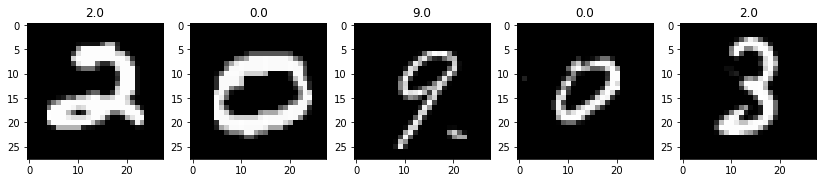

In [28]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [199]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%d\n' % (i, p))

Результаты:

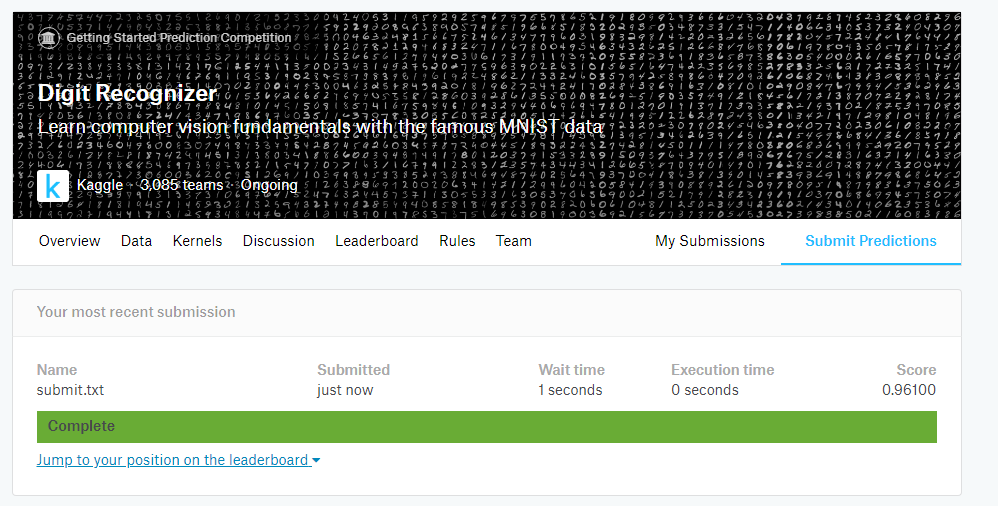

In [205]:
from IPython.display import Image
Image("HW_kaggle.PNG")